In [1176]:
import finance_scrapper as fs
# import importlib
# importlib.reload(fs)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import datetime as dt

%matplotlib inline

# Equalize dates of the data to the target data
def equalize_date(data,target,length=5):
    data = data.iloc[-length:]
    data.index = target.index
    return data

# Restore annual data points based on fully available annual growth data
def restoredata(limited_data, growth_data):
    limited_data = limited_data[-1]
    growth_data = (1+growth_data).iloc[::-1]
    growth_data = np.cumprod(growth_data).iloc[::-1]
    growth_data = growth_data.shift(-1)
    growth_data.iloc[-1] = 1
    
    full_data = limited_data/growth_data
    return full_data

key = 'Enter API Key Here'

# Restoring Data using growth data (restoredata function)

Given a limited dollar-value **($X_{t}$)** data and its fully available growth data **($g_{t}$)**, we can restore the entire dollar-value data for the available period of growth data.

$X_{t} = X_{t-1}(1+g_{t})$

$X_{t-1} = \dfrac{X_{t}}{(1+g_{t})}$

$t-4$: $\dfrac{X_{t}}{(1+g_{t})(1+g_{t-1})(1+g_{t-2})(1+g_{t-3})} = X_{t-4}$

$t-3$: $\dfrac{X_{t}}{(1+g_{t})(1+g_{t-1})(1+g_{t-2})} = X_{t-3}$

$t-2$: $\dfrac{X_{t}}{(1+g_{t})(1+g_{t-1})} = X_{t-2}$

$t-1$: $\dfrac{X_{t}}{(1+g_{t})} = X_{t-1}$

$t$: $\dfrac{X_{t}}{1} = X_{t}$



In [1146]:
ticker = 'AAPL'
# only limited annual data available, but full annual available for IS and some accounts in BS and CF
# For Free users, these parameters do not matter:
limit = 0
period = ''

### Call FS data
# for FS growth, add parameter growth = True
IS = fs.get_income_statement(ticker, limit, key, period)
BS = fs.get_balance_sheet(ticker, limit, key, period)
BS_g = fs.get_balance_sheet(ticker, limit, key, period, growth=True)

ratios = fs.get_financial_ratios(ticker, limit, key,'annual')
fgrowth = fs.get_financial_growth(ticker, limit, key)

### Clean FS data
IS_df = IS.iloc[8:-2].astype(float).iloc[:, ::-1]
BS_df = BS.iloc[8:-2].astype(float).iloc[:, ::-1]

ratio_df = ratios.iloc[1:].astype(float).iloc[:, ::-1]
fgrowth_df = fgrowth.iloc[3:].astype(float).iloc[:, ::-1]

In [1147]:
NI = IS_df.loc['netIncome']
ROE = ratio_df.loc['returnOnEquity']
WASHO = IS_df.loc['weightedAverageShsOut']

ShE = BS_df.loc['totalStockholdersEquity']
ShE_g = BS_g.loc['growthTotalStockholdersEquity']

ShEpsh_g_10Y = fgrowth_df.loc['tenYShareholdersEquityGrowthPerShare']
ShEpsh_g_5Y = fgrowth_df.loc['fiveYShareholdersEquityGrowthPerShare']
ShEpsh_g_3Y = fgrowth_df.loc['threeYShareholdersEquityGrowthPerShare']

# The two growth data of the same subject does not match in values + growth data has limited availability
# The reconstruction of Total Shareholder's Equity directly using its growth 
# Need another way to reconstruct Total Shareholder's Equity
ShE_g, ShE.pct_change()

(date
 2022-09-24    -0.19683
 2021-09-25    -0.03442
 2020-09-26   -0.277926
 2019-09-28   -0.155478
 2018-09-29   -0.200676
 Name: growthTotalStockholdersEquity, dtype: object,
 fillingDate
 2018-11-05         NaN
 2019-10-31   -0.155478
 2020-10-30   -0.277926
 2021-10-29   -0.034420
 2022-10-28   -0.196830
 Name: totalStockholdersEquity, dtype: float64)

# Total Shareholder's Equity (BV) reconstruction

#### Problem:
We are given limited annual Total Shareholder's Equity Data (only recent 5 years provided).\
We want to reconstruct full annual Total Shareholder's Equity Data using limited actual Total Shareholder's Equity per share and its full annual growth data ($g_t$).\
Total Shareholder's Equity growth cannot be used to directly reconstruct, because the growth data is given in
Total Shareholder's Equity **per share**

#### How?
##### 1. Reconstruct full $g_t$ using fully provided 3-Years Growth data (**$G3Y_t$**)
##### 2. Reconstruct full $ShE$ using fully reconstructed 1-Years Growth data (**$g_t$**)
         
#### Materials:
* Shareholder's Equity (**$ShE_t$**) from Balance Sheet (**limited data**: only recent 5 years provided)
* Weighted Average Shares Outstanding (**$WASHO_t$**) from Income Statement (**full data**)
* Shareholder's Equity per share 3-Years Growth (**$G3Y_t$**) from FS growth data (**full data**)

## 1. Reconstruct full $g_t$ using fully provided 3-Years Growth data (**$G3Y_t$**)
Verified calculation of Shareholder's Equity per share (**$ShEpsh_t$**)\
$ShEpsh_t = \dfrac{ShE_t}{WASHO_t}$

Shareholder's Equity per share 1-Year Growth (**$g_t$**) can be calculated\
$g_t = \dfrac{ShEpsh_t}{ShEpsh_{t-1}} - 1$

In [1148]:
ShEpsh = ShE / WASHO.tail(5) # ShE limited to 5Y, WASHO is unlimited
d_ShEpsh = ShEpsh.pct_change() 
d_ShEpsh # we want to reconstruct this growth data first

fillingDate
2018-11-05         NaN
2019-10-31   -0.093747
2020-10-30   -0.231352
2021-10-29    0.003208
2022-10-28   -0.172793
dtype: float64

Relationship between $g_{t}$ and $G3Y_t$:

$G3Y_t = (1+g_{t-2})(1+g_{t-1})(1+g_{t}) - 1$

$G3Y_t$ are known from full data, therefore **constant**

Rearranging above equation and solving gives:

$X_t = \dfrac{(1+G3Y_{t-1})}{(1+G3Y_{t})} = \dfrac{(1+g_{t-3})(1+g_{t-2})(1+g_{t-1})}{(1+g_{t-2})(1+g_{t-1})(1+g_{t})} = \dfrac{(1+g_{t-3})}{(1+g_{t})}$

Since $G3Y_t$ are known from full data, $X_t$ are also **constant.** Therefore:

$g_{t-3} = X_t(1+g_{t}) - 1 = \dfrac{(1+G3Y_{t-1})(1+g_{t})}{(1+G3Y_{t})} - 1$

Now, we can reconstruct $g_{t-3}$ using: $g_{t}, G3Y_{t-1}, G3Y_{t}$ (**All known**)

e.g.\
$g_{t}, G3Y_{t-1}, G3Y_{t}$ ==> $g_{t-3}$\

$g_{5}, G3Y_{4}, G3Y_{5}$ ==> $g_{2}$\
$g_{4}, G3Y_{3}, G3Y_{4}$ ==> $g_{1}$\
$g_{3}, G3Y_{2}, G3Y_{3}$ ==> $g_{0}$\
and so on

Once $g_{1}, g_{2}$ are calculated, we can calculate $g_{3}, g_{4}, g_{5}$ as well:\
$(1+G3Y_{t}) = (1+g_{t-2})(1+g_{t-1})(1+g_{t})$

$g_{t} = \dfrac{(1+G3Y_{t})}{(1+g_{t-2})(1+g_{t-1})} - 1$

e.g.\
$g_{3}= \dfrac{(1+G3Y_{3})}{(1+g_{1})(1+g_{2})} - 1$

$g_{4}= \dfrac{(1+G3Y_{4})}{(1+g_{2})(1+g_{3})} - 1$

$g_{5}= \dfrac{(1+G3Y_{5})}{(1+g_{3})(1+g_{4})} - 1$

In [1149]:
# Relationship between g and G3Y
np.prod(1+d_ShEpsh[-3:]) - 1, "==", ShEpsh_g_3Y[-1]

(-0.3621293491290547, '==', -0.3621293491290547)

In [1150]:
# uses 3Y growth data which is fully available
constant_G5 = ShEpsh_g_3Y[-1]
constant_G4 = ShEpsh_g_3Y[-2]
constant_G3 = ShEpsh_g_3Y[-3]

# using gt=5, index -1 --> get g2
X = (1+constant_G4)/(1+constant_G5)
g2 = X * (1+d_ShEpsh[-1]) - 1

# using gt=4, index -2 --> g1
Y = (1+constant_G3)/(1+constant_G4)
g1 = Y * (1+d_ShEpsh[-2]) - 1

# deduce g3 using g1 and g2
g3 = (1+constant_G3)/((1+g1)*(1+g2)) - 1

# deduce g4 using g2 and g3
g4 = (1+constant_G4)/((1+g2)*(1+g3)) - 1

# deduce g5 using g3 and g4
g5 = (1+constant_G5)/((1+g3)*(1+g4)) - 1


g1, g2, (g3, d_ShEpsh[-3]), (g4, d_ShEpsh[-2]), (g5, d_ShEpsh[-1])

(-0.15843590542760688,
 -0.09374720846516549,
 (-0.2313523831968799, -0.23135238319687979),
 (0.0032080590434591105, 0.0032080590434591105),
 (-0.1727927674458496, -0.1727927674458497))

In [1151]:
# check g3
(1+g1)*(1+g2)*(1+g3) - 1 == constant_G3

True

In [1152]:
# check all g1~5
(1+g1)*(1+g2)*(1+g3)*(1+g4)*(1+g5) - 1, ShEpsh_g_5Y[-1]

(-0.5135153119200997, -0.5135153119200997)

In [1153]:
# build DF for ShEpsh_g_1Y
ShEpsh_g_1Y = pd.DataFrame(['NaN'] * len(ShEpsh_g_3Y.index[:-5]))
ShEpsh_g_1Y.index = ShEpsh_g_3Y.index[:-5] #ShEpsh
ShEpsh_g_1Y = ShEpsh_g_1Y.rename(columns={0:'d_ShEpsh'})

# Will be added to ShEpsh_g_1Y after ShEpsh_g_1Y is filled
add_df = pd.DataFrame([g1,g2,g3,g4,g5],index = ShEpsh_g_3Y.index[-5:])
add_df = add_df.rename(columns={0:'d_ShEpsh'})
ShEpsh_g_1Y = ShEpsh_g_1Y.append(add_df)

d_ShEpsh, ShEpsh_g_1Y.iloc[-5:]
# successfully created g1 with method replicating d_ShEpsh

(fillingDate
 2018-11-05         NaN
 2019-10-31   -0.093747
 2020-10-30   -0.231352
 2021-10-29    0.003208
 2022-10-28   -0.172793
 dtype: float64,
             d_ShEpsh
 date                
 2018-09-29 -0.158436
 2019-09-28 -0.093747
 2020-09-26 -0.231352
 2021-09-25  0.003208
 2022-09-24 -0.172793)

In [1154]:
# to get: ShEpsh_g_1Y index = -6
# use ShEpsh_g_3Y index -3, -2; ShEpsh_g_1Y index = -3

for idx in range(len(ShEpsh_g_1Y)-5): # fill from 6th from the last to the first data
    constant_Gt = ShEpsh_g_3Y[-(3+idx)]
    constant_Gt_L1 = ShEpsh_g_3Y[-(4+idx)]
    gt = ShEpsh_g_1Y.iloc[-(3+idx)]
        
    X = (1+constant_Gt_L1)/(1+constant_Gt)
    gfill = X * (1+gt) - 1
    
    ShEpsh_g_1Y.iloc[-(idx+6)] = gfill # start from 6th from the last and fill data

ShEpsh_g_1Y.head()

,d_ShEpsh
date,
1985-09-30,0.0
1986-09-30,0.20256
1987-09-30,0.180408
1988-09-30,0.209273
1989-09-30,0.500511


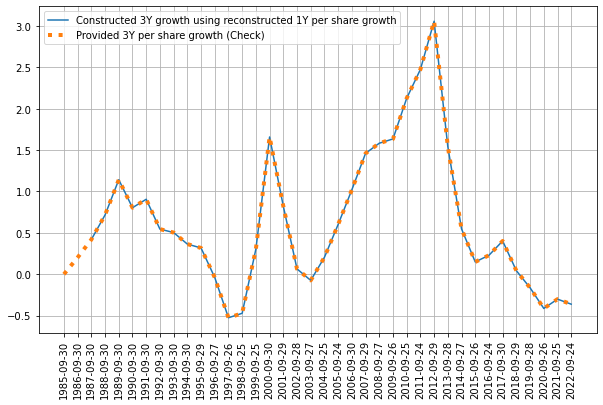

In [1155]:
# Check work
constructed_3Y_g = ((1+ShEpsh_g_1Y)*(1+ShEpsh_g_1Y).shift(1)*(1+ShEpsh_g_1Y).shift(2)) - 1
constructed_3Y_g = equalize_date(constructed_3Y_g, ShEpsh_g_3Y, 0)
plt.figure(figsize=(10,6))
plt.plot(constructed_3Y_g, label = 'Constructed 3Y growth using reconstructed 1Y per share growth')
plt.plot(ShEpsh_g_3Y,linestyle=':',linewidth=4, label = 'Provided 3Y per share growth (Check)')
plt.xticks(rotation=90)
plt.grid()
plt.legend();

In [1177]:
# successful restoration of Shareholder's Equity per share
rst_ShEpsh = restoredata(ShEpsh,ShEpsh_g_1Y).rename(columns={'d_ShEpsh': 'ShEpsh'})
rst_ShEpsh.head()

,ShEpsh
date,
1985-09-30,0.040157
1986-09-30,0.048291
1987-09-30,0.057003
1988-09-30,0.068932
1989-09-30,0.103433


In [1172]:
# Successfully reconstructed Total Shareholders' Equity
WASHO_ = equalize_date(WASHO, rst_ShEpsh['ShEpsh'], 0) # .iloc[1:-1]
WASHO_

constructed_ShE = rst_ShEpsh['ShEpsh'] * WASHO_
ShE, constructed_ShE[-5:]

(fillingDate
 2018-11-05    1.071470e+11
 2019-10-31    9.048800e+10
 2020-10-30    6.533900e+10
 2021-10-29    6.309000e+10
 2022-10-28    5.067200e+10
 Name: totalStockholdersEquity, dtype: float64,
 date
 2018-09-29        107147000000.0
 2019-09-28         90488000000.0
 2020-09-26    65338999999.999985
 2021-09-25    63089999999.999985
 2022-09-24         50672000000.0
 dtype: object)

In [1173]:
constructed_ShE = equalize_date(constructed_ShE, NI, 0) # .iloc[1:-1]

EndE = constructed_ShE
AvgE = (constructed_ShE + constructed_ShE.shift(1))/2

roe_avgE = NI/AvgE
roe_endE = NI/EndE

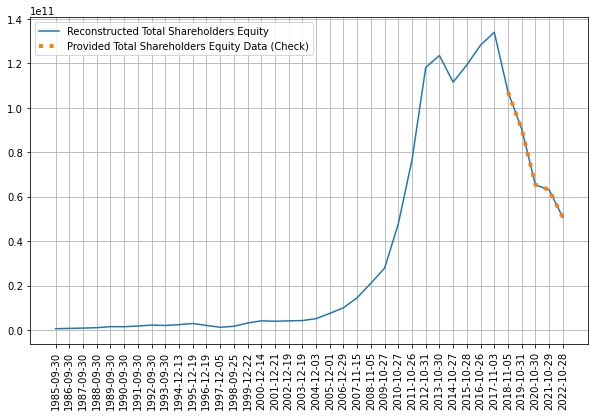

In [1174]:
ShE = equalize_date(ShE, constructed_ShE[-5:])

plt.figure(figsize=(10,6))
plt.plot(constructed_ShE, label='Reconstructed Total Shareholders Equity')
plt.plot(ShE, linewidth=4, linestyle=':', label='Provided Total Shareholders Equity Data (Check)')
plt.xticks(rotation=90)
plt.grid()
plt.legend();

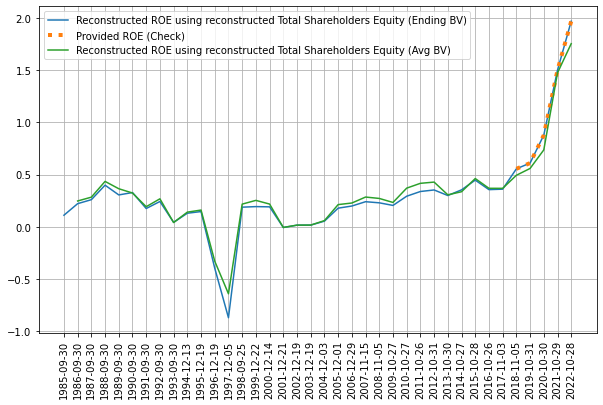

In [1175]:
ROE = equalize_date(ROE,roe_endE[-5:])

plt.figure(figsize=(10,6))
plt.plot(roe_endE, label='Reconstructed ROE using reconstructed Total Shareholders Equity (Ending BV)')
plt.plot(ROE, linewidth=4, linestyle=':', label='Provided ROE (Check)')
plt.plot(roe_avgE, label='Reconstructed ROE using reconstructed Total Shareholders Equity (Avg BV)')

plt.xticks(rotation=90)
plt.grid()
plt.legend();